![](https://storage.googleapis.com/kaggle-competitions/kaggle/30894/logos/header.png)
# G-Research Crypto - Exploration (FR)

Dans le concours de prédiction G-Research Crypto, les participants ont le défi de prédire les rendements des prix sur un ensemble de crypto-monnaies majeures. 

## Crypto-monnaies
Elles sont devenues un marché extrêmement populaire et volatile, offrant des rendements massifs (ainsi que des pertes) aux investisseurs. 
Des milliers de crypto-monnaies ont été créées avec quelques-unes majeures dont beaucoup d'entre vous ont entendu parler, notamment le Bitcoin (BTC), l'Ethereum (ETH) ou le Dogecoin (DOGE).
Les variations de prix entre les différentes crypto-monnaies sont fortement interconnectées. 
Par exemple, Bitcoin a toujours été un moteur majeur des changements de prix entre les crypto-monnaies, mais d'autres pièces ont également un impact sur le marché.

## Prévoir les rendements
Une tâche fondamentale de la modélisation financière consiste à prédire comment les prix se comporteront dans un proche avenir. 
En utilisant les séries chronologiques de prix historiques comme données d'apprentissage, nous voulons prédire si les prix vont monter ou descendre, et de combien, à savoir les rendements des actifs.

Dans ce concours, le défi est de créer des modèles d'apprentissage automatique pour prédire les rendements de 14 crypto-monnaies populaires, sur une échelle de temps allant de quelques minutes à quelques heures. 
On possède des millions de lignes de données de trading de crypto-monnaie minute par minute, avec lesquelles il faut concevoir des modèles de prévision pour les 14 actifs simultanément. 
Les prédictions sont évaluées en fonction de leur corrélation avec les données de marché réelles collectées au cours de la période d'évaluation de trois mois après la clôture du concours.

La prédiction de rendements de crypto-monnaie reste une tâche de prévision ouverte et extrêmement difficile. 
Il s'agit d'un domaine problématique fascinant pour la communauté ML étant donné l'extrême volatilité des actifs, la nature non stationnaire des données, la manipulation du marché et des mèmes, la corrélation entre les actifs et l'évolution très rapide des conditions de marché. 

## Notes
Ici est tout d'abord présenté la structure et les éléments de l'ensemble de données, certaines propriétés statistiques pertinentes.
Puis la construction de quelques modèles de base de ML.
Pour finir sur une soumission de code.

Références utilisées : 
* [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition)

# Libraries et Fonctions

In [43]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import datetime

In [68]:
totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

# Données

In [2]:
data_folder = "../input/g-research-crypto-forecasting/"
data_folder = ""
df_train = pd.read_csv(data_folder + 'train.csv')
df_asset_details = pd.read_csv(data_folder + 'asset_details.csv').sort_values("Asset_ID")

In [4]:
df_train

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.500000,2357.140000,2374.590000,1.923301e+01,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.530000,8.530000,8.530000,7.838000e+01,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.800000,13666.110000,13850.176000,3.155006e+01,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.659600,7.656700,7.657600,6.626713e+03,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.920000,25.874000,25.877000,1.210873e+02,25.891363,-0.008264
...,...,...,...,...,...,...,...,...,...,...
24236801,1632182400,9,775.0,157.181571,157.250000,156.700000,156.943857,4.663725e+03,156.994319,NaN
24236802,1632182400,10,34.0,2437.065067,2438.000000,2430.226900,2432.907467,3.975460e+00,2434.818747,NaN
24236803,1632182400,13,380.0,0.091390,0.091527,0.091260,0.091349,2.193732e+06,0.091388,NaN
24236804,1632182400,12,177.0,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,NaN


## Caractéristiques

Nous pouvons voir que chaque ligne contient les données de trading d'un actif, à une minute donnée, décrites comme suit :
* `timestamp` : tous les **horodatage** sont renvoyés sous forme d'horodatages Unix secondes (le nombre de secondes écoulées depuis 1970-01-01 00:00:00.000 UTC). 
Les horodatages de cet ensemble de données sont des multiples de 60, indiquant des données **minute par minute**.
* `Asset_ID` : l'**identifiant** de l'actif correspondant à l'une des crypto-monnaies.
Le mappage de Asset_ID à l'actif cryptographique est contenu dans `asset_details.csv`.
* `Count` : nombre total de **transactions** dans l'intervalle de temps (dernière minute).
* `Open` : cours d'**ouverture** de l'intervalle de temps (en USD).
* `Haut` : prix le plus **élevé** atteint au cours de l'intervalle de temps (en USD).
* `Bas` : prix le plus **bas** atteint pendant l'intervalle de temps (en USD).
* `Clôture` : cours de **clôture** de l'intervalle de temps (en USD).
* `Volume` : **quantité d'actif** achetée ou vendue, affichée dans la devise de base USD.
* `VWAP` : Le **prix moyen** de l'actif sur l'intervalle de temps, pondéré par le volume. Le VWAP est une forme agrégée de données commerciales.
* `Cible` : cible de **prédiction** pour l'actif sur un horizon de **15 minutes**.

La seconde base de données contient les informations sur les différents actifs :
* le mappage `Asset_ID` vers les noms des actifs `Asset_Name`
* le poids de `Weight` chaque actif utilisé pour peser leur importance relative dans la métrique d'évaluation.

In [5]:
df_asset_details

,Asset_ID,Weight,Asset_Name
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
0,2,2.397895,Bitcoin Cash
10,3,4.406719,Cardano
13,4,3.555348,Dogecoin
3,5,1.386294,EOS.IO
5,6,5.894403,Ethereum
4,7,2.079442,Ethereum Classic
11,8,1.098612,IOTA
6,9,2.397895,Litecoin


# Pré-traitements
## Valeurs manquantes 
Vérifions la portée maximale et s'il ne manque pas des minutes pour les différentes crypto-monnaies :

In [6]:
t_range = (df_train['timestamp'].max() - df_train['timestamp'].min()) // 60 +1
print(f"Portée maximale : {t_range} minutes / {t_range/60/24/365.25:.2f} ans")

Portée maximale : 1956960 minutes / 3.72 ans


Les données d'actifs manquantes, pour une minute donnée, ne sont pas représentées par des NaN, mais plutôt par l'absence de ces lignes.  
Nous pouvons vérifier le nombre de minutes par rapport au nombre maximum de minutes possible sur la période.

In [47]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

Text(0, 0.5, 'Ecart temporel relatif')

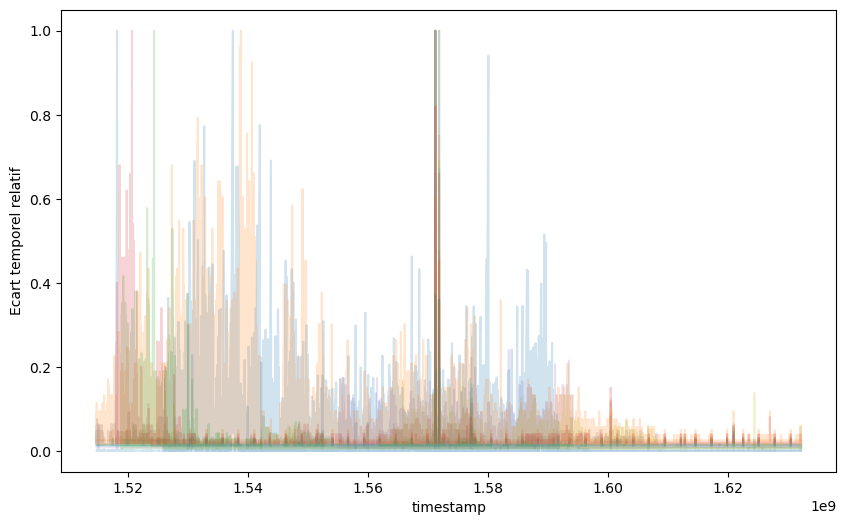

In [49]:
plt.figure(figsize=(10,6))
for i, row in df_asset_details.iterrows():
    tmp = df_train[df_train["Asset_ID"]==row["Asset_ID"]]
    plt.plot(tmp.timestamp, tmp.timestamp.diff()/tmp.timestamp.diff().max(), alpha=0.2)
    # plt.title(row["Asset_ID"])
    # plt.show()
plt.xlabel("timestamp")
plt.ylabel('Ecart temporel relatif')
    

In [50]:
Lmax = (df_train['timestamp'].max() - df_train['timestamp'].min()) // 60
print(f"{'ID':2}  {'#MISSING':8}  {'PERCENT':6}  {'NOM'}")
for i, row in df_asset_details.iterrows():
    ID = row['Asset_ID']
    tmp = df_train[df_train["Asset_ID"]==ID]
    L = len(tmp)
    missing = Lmax - L
    name = row['Asset_Name']
    print(f"{ID:2}  {missing:8}  {100*missing/Lmax:6.2f}%  {name}")

ID  #MISSING  PERCENT  NOM
 0     14340    0.73%  Binance Coin
 1       677    0.03%  Bitcoin
 2      3422    0.17%  Bitcoin Cash
 3    165092    8.44%  Cardano
 4    800093   40.88%  Dogecoin
 5      1819    0.09%  EOS.IO
 6       759    0.04%  Ethereum
 7      5832    0.30%  Ethereum Classic
 8    364888   18.65%  IOTA
 9       929    0.05%  Litecoin
10   1286462   65.74%  Maker
11    255698   13.07%  Monero
12    178210    9.11%  Stellar
13     82399    4.21%  TRON


Il manque un bon nombre de données pour certaines crypto-monnaies notamment **Stellar** (6%), **Dogecoin** (7%), **IOTA** (9%), **Monero** (13%) et surtout **Maker** avec plus de **56%** de données manquantes.  
Pour travailler avec la plupart des modèles de séries chronologiques, nous devons prétraiter nos données dans un format sans intervalle de temps. 
Pour combler les lacunes, nous pouvons utiliser la méthode [`.reindex()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html) pour le remplissage avancé, en comblant les lacunes avec la valeur valide suivante (`method='backfill'`) puisque c'est les données les plus récentes que nous possédons.

In [51]:
IDs = df_train['Asset_ID'].unique()
tmin, tmax = df_train['timestamp'].min(), df_train['timestamp'].max()
df_train = df_train.set_index('timestamp')
df = pd.DataFrame()
for i in IDs:
    sub_reindexed = df_train.loc[df_train['Asset_ID'] == i].reindex(range(tmin, tmax+60, 60), method='nearest')
    df = pd.concat([df, sub_reindexed], axis=0)

In [10]:
print("Taille initiale : ", len(df_train))
print("    + manquants : ", len(df_train) + int(mtmt.loc['total'].sum()))
print("Taille cible    : ", t_range*len(IDs))
print("Taille finale   : ", len(df))
#TODO: Le nombre d'éléments manquant a été sous-estimé : outil à revoir
del df_train

Taille initiale :  24236806
    + manquants :  26080043
Taille cible    :  27397440
Taille finale   :  27397440


In [52]:
tmp = df.isna().sum(0)
tmp[tmp !=0]

VWAP           18
Target    2603775
dtype: int64


Nous pouvons également voir qu'il y a beaucoup de valeurs manquantes pour la colonnes `Target` et quelques-unes pour la colonne `VWAP`. 

# Sauvegarde

In [12]:
df.to_csv(data_folder + 'train_cleaned.csv')

# Visualisation
## Graphiques en chandeliers
Le format des données de trading est une forme agrégée de données de marché, y compris pour l'ouverture, le haut, le bas et la clôture. 
Nous pouvons visualiser ces données à travers le graphique à barres en chandelier couramment utilisé, qui permet aux traders d'effectuer une analyse technique sur les valeurs intrajournalières. 
* La **longueur du corps de la barre** représente la fourchette de prix **entre l'ouverture et la clôture** de la négociation de ce jour. 
Lorsque la barre est rouge, cela signifie que la clôture était inférieure à l'ouverture, et verte dans le cas contraire. 
Ceux-ci sont également appelés chandeliers haussiers et baissiers. 
* Les **mèches au-dessus et au-dessous** des barres indiquent les **prix haut et bas** du trading de cet intervalle.

In [57]:
idi, last = 1, 200  # 1 pour Bitcoin et 200 dernières minutes
sub = df_train[df_train["Asset_ID"]==1].set_index("timestamp").iloc[-last:] 
fig = go.Figure(data=[go.Candlestick(
    x=sub.index, 
    open=sub['Open'], 
    high=sub['High'], 
    low=sub['Low'], 
    close=sub['Close'])])
fig.show()

## Première comparaison

C:\Anaconda3\envs\forecasting\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


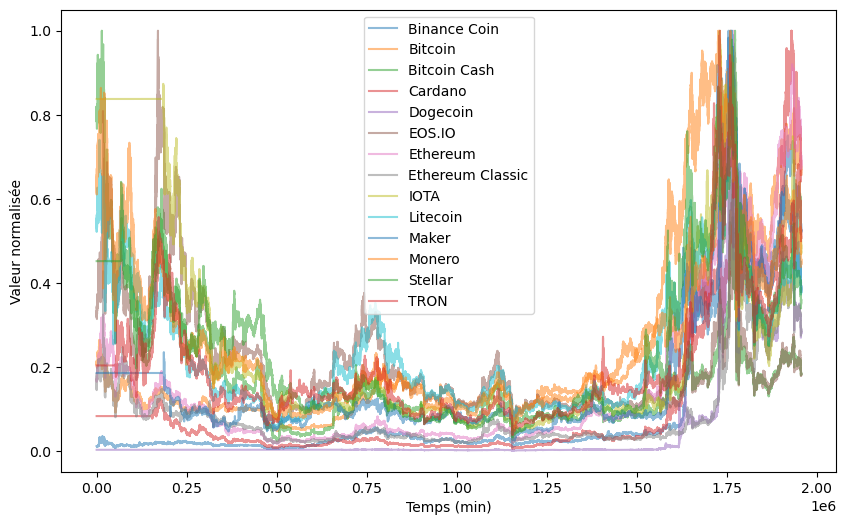

In [67]:
f, ax = plt.subplots(figsize=(10,6))
for i in sorted(IDs):
    name = df_asset_details[df_asset_details["Asset_ID"]==i]["Asset_Name"].values[0]
    values = df[df['Asset_ID']==i]['Close'].values
    ax.plot(values / values.max(), label=name, alpha=0.5)
plt.legend()
plt.xlabel('Temps (min)')
plt.ylabel('Valeur normalisée')
plt.show()

Les actifs ont une histoire assez différente, mais on voit clairement de forte inter-corrélations.  
Un meilleur format pour analyser de tels mouvements consiste à calculer les rendements des actifs.

In [ ]:
# Premiers relevés manquants pour certaines crypto-monnaies :
# ID   start  
#  3  160000   8%
#  4  680000  35%
#  8  190000  10%
# 10  190000  10%
# 12   70000   4%
# 13   60000   3%

## Log Return
Afin d'analyser les variations de prix d'un actif, nous pouvons traiter la différence de prix. 
Cependant, différents actifs présentent des échelles de prix différentes, de sorte que leurs rendements ne sont pas facilement comparables. 
Nous pouvons résoudre ce problème en calculant plutôt le pourcentage de variation du prix, également appelé rendement. 
Ce rendement coïncide avec la variation en pourcentage de notre capital investi.

Les rendements sont largement utilisés en finance, mais les rendements logarithmiques sont préférés pour la modélisation mathématique des séries chronologiques, car ils s'additionnent dans le temps. 
De plus, bien que les retours normaux ne puissent pas descendre en dessous de -100 %, les logarithmes des retours ne sont pas limités.

Pour calculer le **log return**, on peut simplement prendre le logarithme du rapport entre deux prix consécutifs. 
La première ligne aura un retour vide car la valeur précédente est inconnue, donc le point de données de retour vide sera supprimé.

In [55]:
def log_return(series, periods=1):
    """Function to compute the log return."""
    return np.log(series).diff(periods=periods)

In [56]:
for i in sorted(IDs):
    df.loc[df['Asset_ID'] == i, 'Log_return'] = log_return(df.loc[df['Asset_ID'] == i, 'Close'])

C:\Anaconda3\envs\forecasting\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


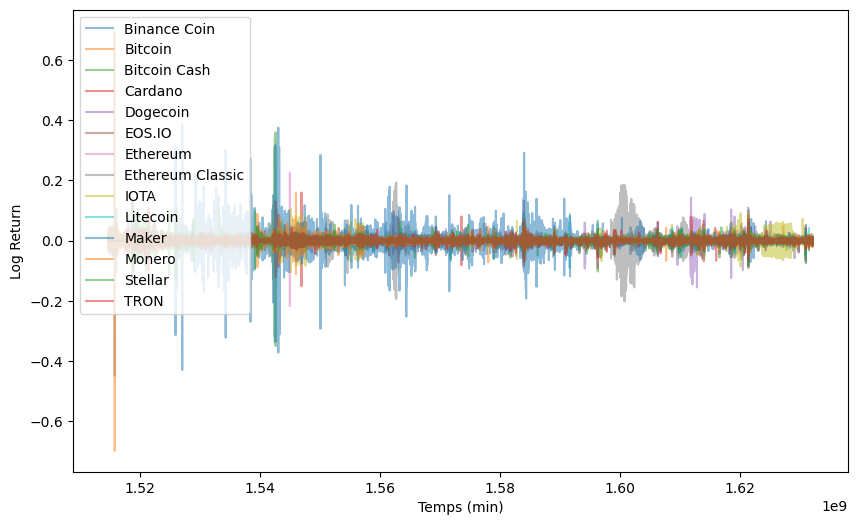

In [60]:
plt.figure(figsize=(10,6))
for i in sorted(IDs):
    name = df_asset_details[df_asset_details["Asset_ID"]==i]["Asset_Name"].values[0]
    plt.plot(df.loc[df['Asset_ID'] == i, 'Log_return'][1:], label=name, alpha=0.5)
plt.legend()
plt.xlabel('Temps (min)')
plt.ylabel('Log Return')
plt.show()

Le signal ressemble maintenant plus à du bruit blanc, avec moins de dérive que la série chronologique des prix.

## Corrélation entre les actifs
Nous avons émis l'hypothèse avant que les rendements des actifs cryptographiques puissent présenter une certaine corrélation.
Vérifions cela plus en détail maintenant.
Nous pouvons vérifier comment la corrélation entre Bitcoin et Ethereum évolue dans le temps pour une période plus courte.

In [72]:
two_assets

,BTC,ETH
timestamp,,
1514764920,-0.001595,-0.000335
1514764980,-0.001939,-0.001027
1514765040,-0.002414,-0.000543
1514765100,-0.003137,-0.001898
1514765160,-0.000569,-0.000687
...,...,...
1632182160,-0.002007,-0.003137
1632182220,-0.000910,-0.001305
1632182280,-0.000770,-0.001165


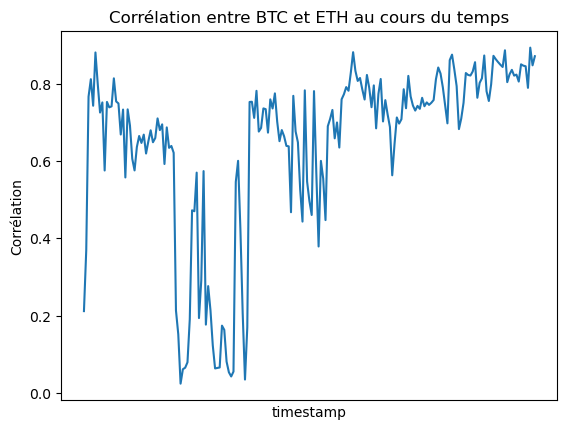

In [58]:
two_assets = pd.concat([
    df.loc[df['Asset_ID'] == 1, 'Log_return'][1:],
    df.loc[df['Asset_ID'] == 6, 'Log_return'][1:]
    ], axis=1)
two_assets.columns = ['BTC','ETH']

# group consecutive rows and use .corr() for correlation between columns
corr_time = two_assets.groupby(two_assets.index//(10000*60)).corr().loc[:,"BTC"].loc[:,"ETH"]

corr_time.plot()
plt.xticks([])
plt.ylabel("Corrélation")
plt.title("Corrélation entre BTC et ETH au cours du temps")
plt.show()

La corrélation entre les actifs est élevée mais variable. 
Ici, nous pouvons voir qu'il y a une dynamique changeante au fil du temps, et c'est essentiel pour ce défi : comment effectuer des prévisions dans un environnement hautement non stationnaire.

Un comportement stationnaire d'un système ou d'un processus est caractérisé par des propriétés statistiques non changeantes dans le temps telles que la moyenne, la variance et l'autocorrélation. 
D'autre part, un comportement non stationnaire est caractérisé par un changement continu des propriétés statistiques au cours du temps. 
La stationnarité est importante car de nombreux outils analytiques utiles et des tests et modèles statistiques en dépendent.

Nous pouvons également vérifier la corrélation entre tous les actifs en visualisant la matrice de corrélation. 

In [69]:
all_assets_2021 = pd.DataFrame([])
for asset_id, asset_name in zip(df_asset_details.Asset_ID, df_asset_details.Asset_Name):
    lret = df.loc[df["Asset_ID"]==asset_id, 'Log_return'].loc[totimestamp('01/01/2021'):totimestamp('01/05/2021')]
    all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")

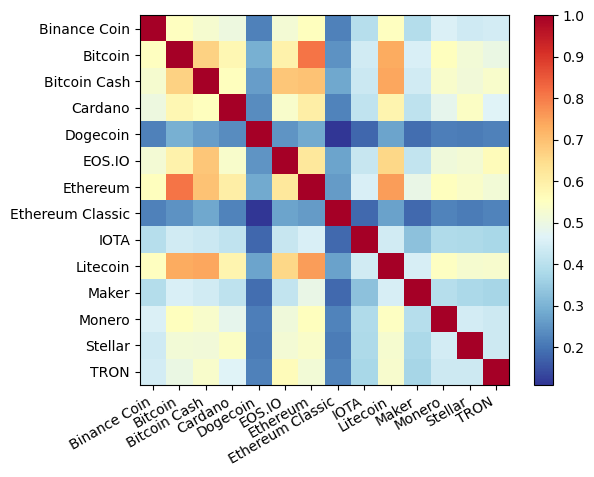

In [94]:
plt.imshow(all_assets_2021.corr(), cmap='RdYlBu_r')
plt.yticks(df_asset_details.Asset_ID.values, df_asset_details.Asset_Name.values)
plt.xticks(df_asset_details.Asset_ID.values, df_asset_details.Asset_Name.values, rotation=30, ha='right')
plt.colorbar()
plt.show()

Notons comment certains actifs ont une corrélation par paires beaucoup plus élevée que d'autres.  
Il est nécessaire d'effectuer des analyses statistiques supplémentaires pour mieux comprendre l'ensemble de données, y compris l'autocorrélation, la décomposition de séries chronologiques et les tests de stationnarité.